# Dimensionality reduction of inferred state space

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_model, plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Get design matrix

Get session data for corresponding session (only one available for now)

In [2]:
# Parameters
bin_size = 0.1

one = ONE()

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
os.chdir(data_path)
design_matrices = os.listdir(data_path)

## Parameters

In [3]:
num_iters = 100
num_train_batches = 5
last_state = 60  # Test up until last_state Ks
state_step = 5
start_step = 2
method = 'kmeans'

## Preprocess list of design matrices

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
session_all = defaultdict(list)
test_all = defaultdict(list)

for m, mat in enumerate(design_matrices):
   
    # Trials data
    session = design_matrices[m][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]

    training_set = np.array(design_matrix[var_names]).copy() 
    
    """
    # Keep some fraction of the data for the test set and don't touch it!
    inpt = training_set
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    test_length = int(length/5)
    
    # Leave test set as the middle 5th part (to avoid effects of early/late session)
    training_set = jnp.concatenate([inpt[:test_length*2], inpt[-test_length*2:]])
    test_set = inpt[test_length*2:test_length*3]
    """
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)  # norm='max'
      normalized = normalizer.transform(standardized)
      
      # Save results
      matrix_all[mat].append(normalized)
      session_all[mat].append(session_trials)
      #test_all[mat].append(test_set)
    

## Fit optimal-state Gaussian HMM

In [5]:
num_states = 100  #This needs to be chosen manually!

# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

In [6]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:1]):
    #ses = 'design_matrix_d23a44ef-1402-4ed7-97f5-47e9a7a504d9_0.1'
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code on original file)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="prior", initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])

    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:277: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learned_params = learned_params.append(df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:277: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learned_params = learned_params.append(df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:277: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learned_params = learned_params.append(df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:277: Fu

In [8]:
num_states = len(states)
X_learned_params = []
for s, state in enumerate(range(num_states)):
    
    df = pd.DataFrame(columns=[var_names ], index=range(1))
    for v, var in enumerate(var_names):
        value = np.nanmean(fit_params[2].means[:].T[v][s, :])
        df[var] = value
    #learned_params = learned_params.append(df)
    if s == 0:
        X_learned_params = np.array(df)
    else:
        X_learned_params = np.vstack((X_learned_params, np.array(df)))

## PCA

In [10]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = X_learned_params # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


In [13]:
np.shape(X_reduced)

(100, 10)

In [25]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['state'], index=range(num_states))
augmented_data['state'] = range(num_states)
augmented_data['pc1'] = X_reduced[:, 0].transpose()
augmented_data['pc2'] = X_reduced[:, 1].transpose()
augmented_data['pc3'] = X_reduced[:, 2].transpose()
augmented_data['pc4'] = X_reduced[:, 3].transpose()
augmented_data['pc5'] = X_reduced[:, 4].transpose()
augmented_data['pc6'] = X_reduced[:, 5].transpose()
augmented_data['pc7'] = X_reduced[:, 6].transpose()
augmented_data['pc8'] = X_reduced[:, 7].transpose()
augmented_data['pc9'] = X_reduced[:, 8].transpose()
augmented_data['pc10'] = X_reduced[:, 9].transpose()

Text(0, 0.5, '% Variance explained')

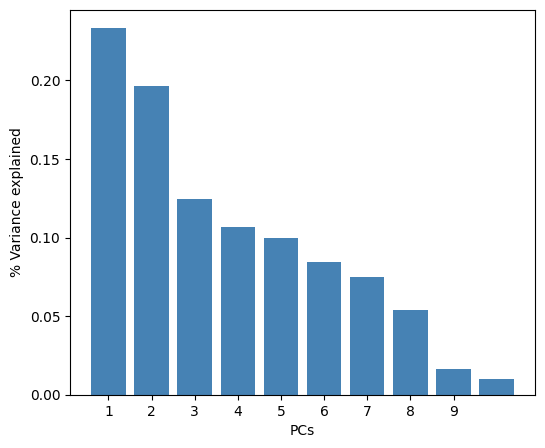

In [26]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

<AxesSubplot: xlabel='pc1', ylabel='pc2'>

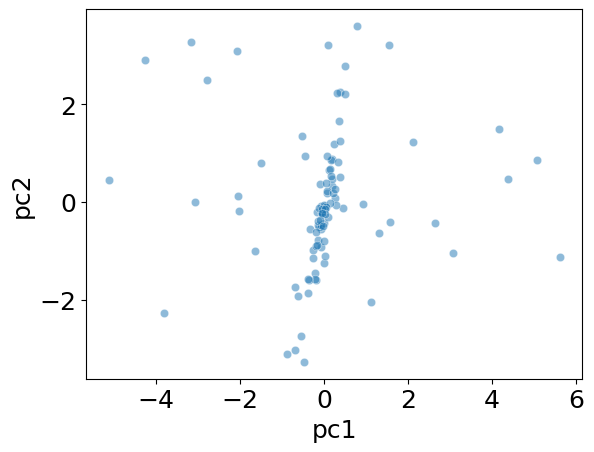

In [29]:
sns.scatterplot(x='pc1', y='pc2', data=augmented_data, alpha=0.5)

In [ ]:
augmented_data
var_names = ['avg_wheel_vel', 'pupil_diameter',
    'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
    'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
    'pupil_speed_Y', 'Gaussian_licks']

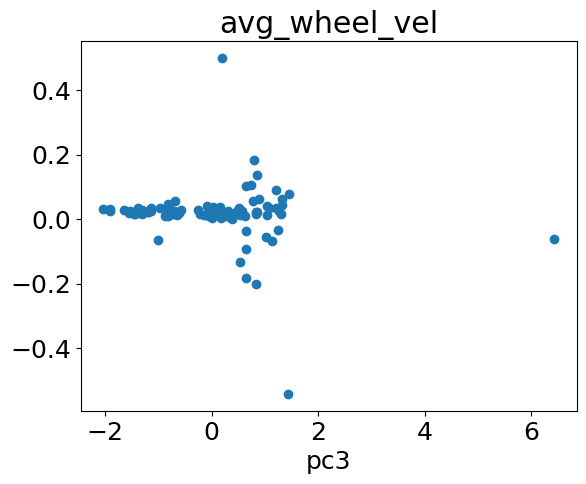

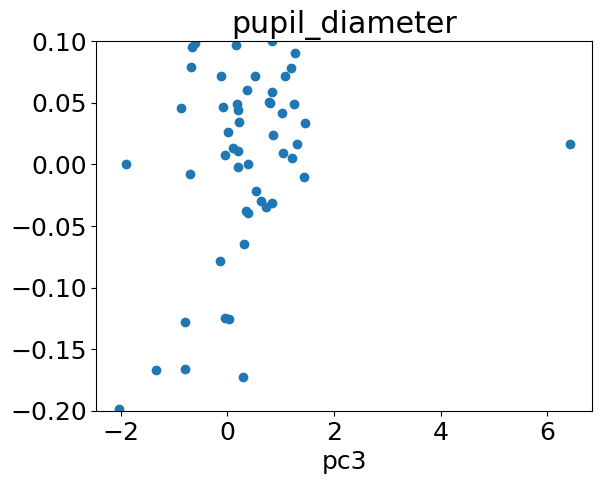

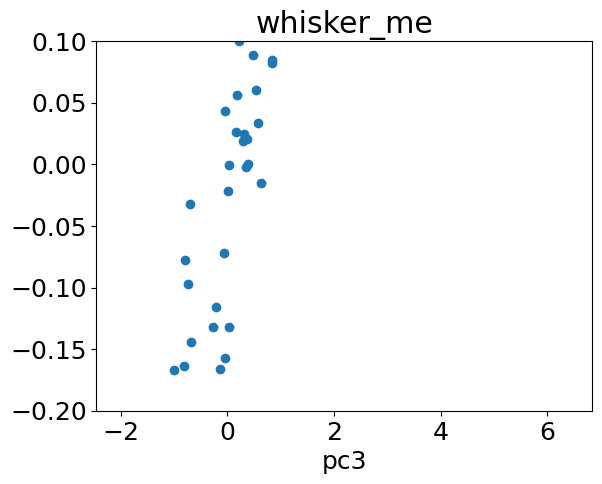

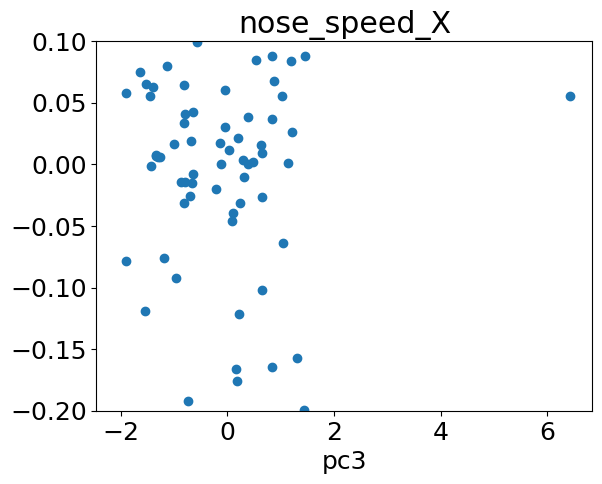

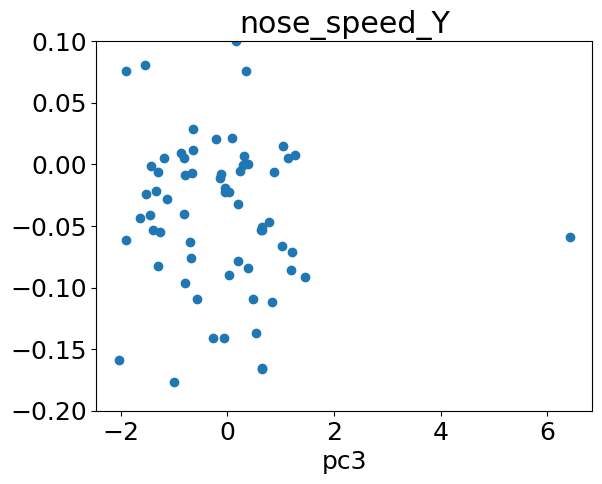

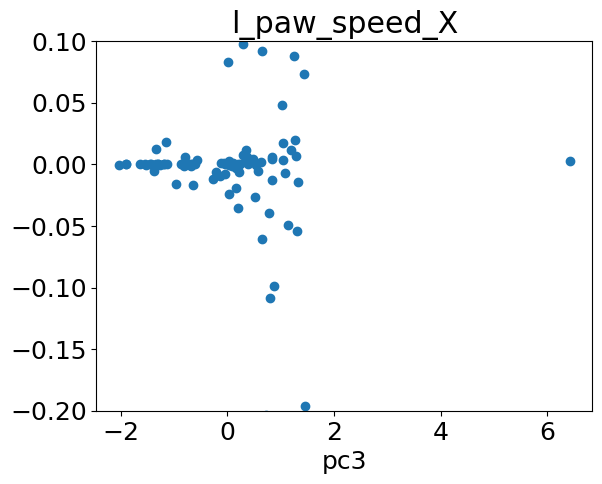

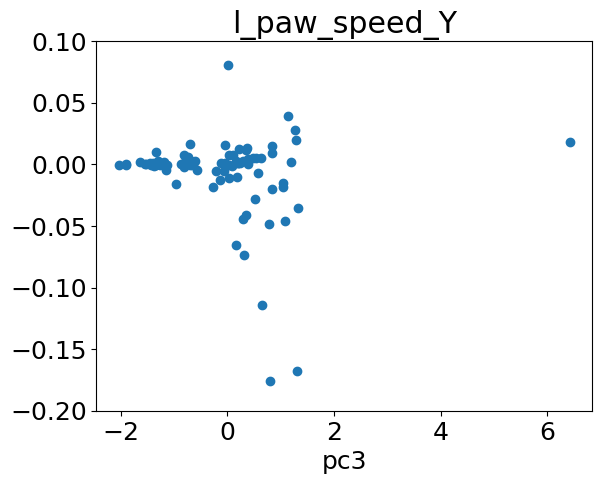

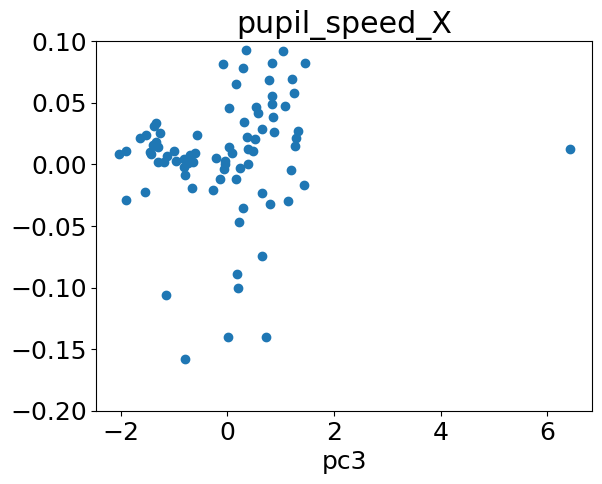

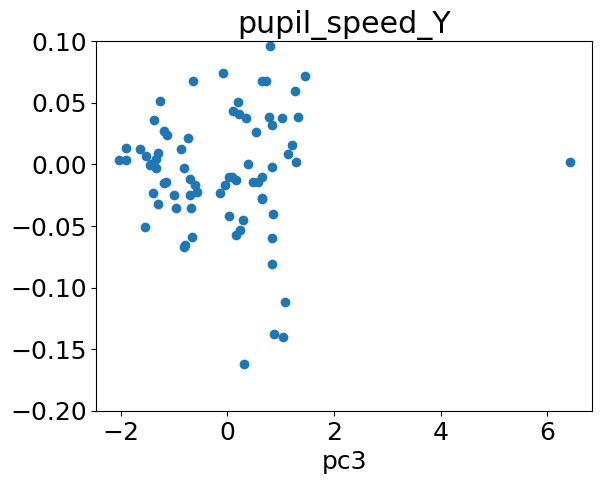

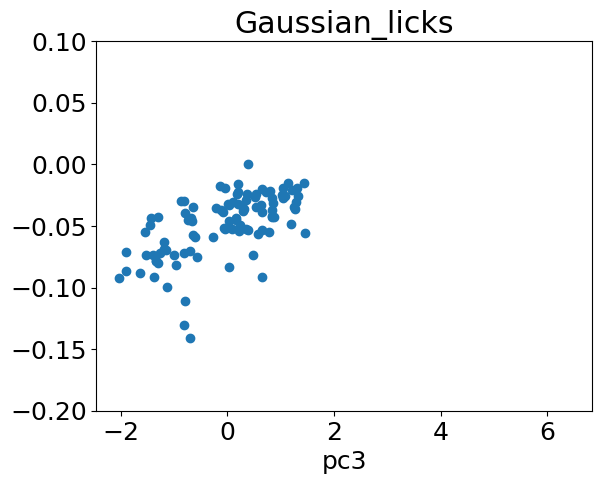

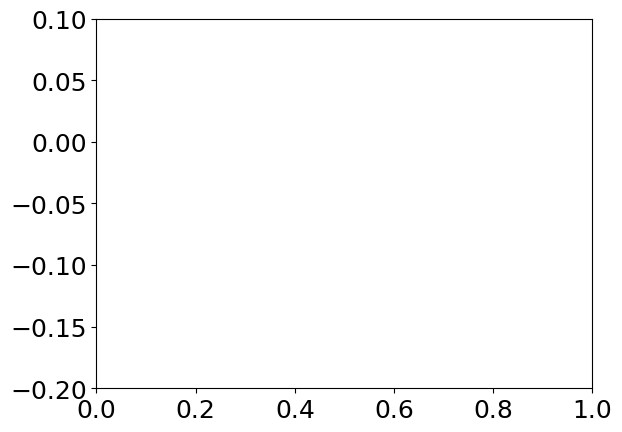

In [53]:
pc = 'pc3'
for v, var in enumerate(var_names):
    plt.scatter(np.array(augmented_data[pc]), X_learned_params[:, v])
    plt.xlabel(pc)
    plt.title(var)
    plt.show()


In [39]:
np.shape(X_learned_params[:, v])

(100,)

In [ ]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix'

os.chdir(data_path)

pickle.dump(augmented_data, open("design_matrix_dim_reduc", "wb"))

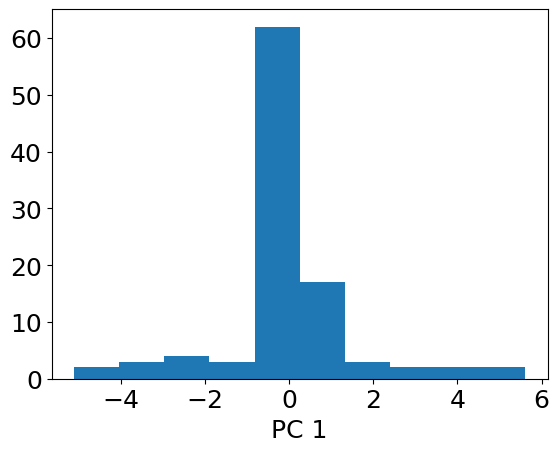

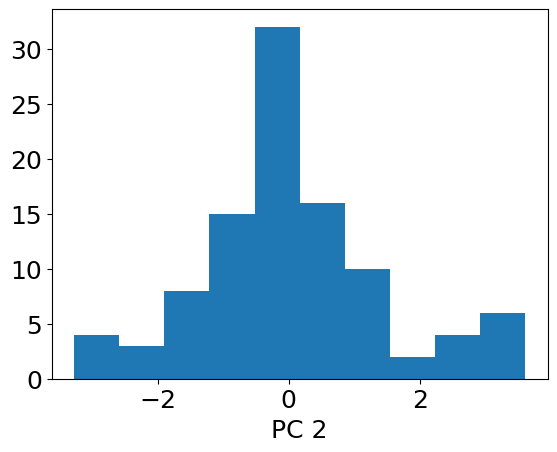

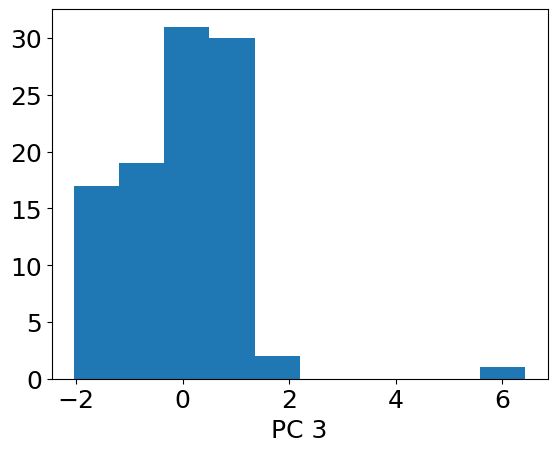

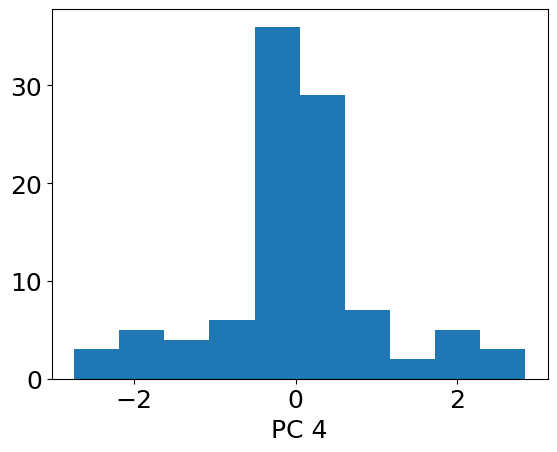

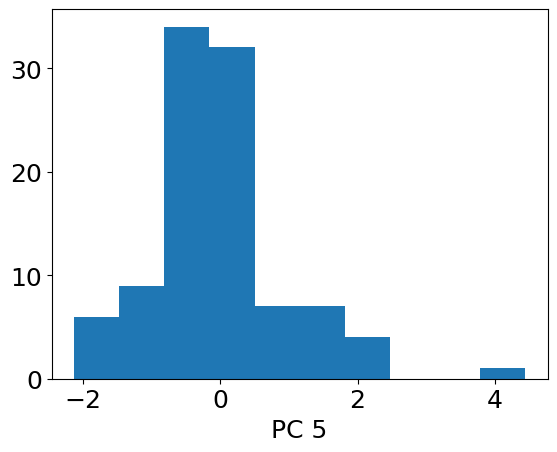

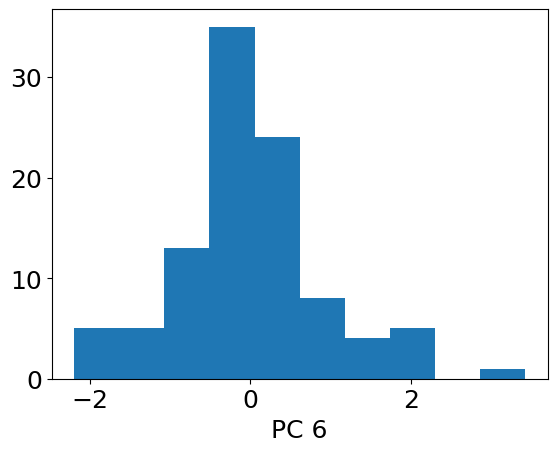

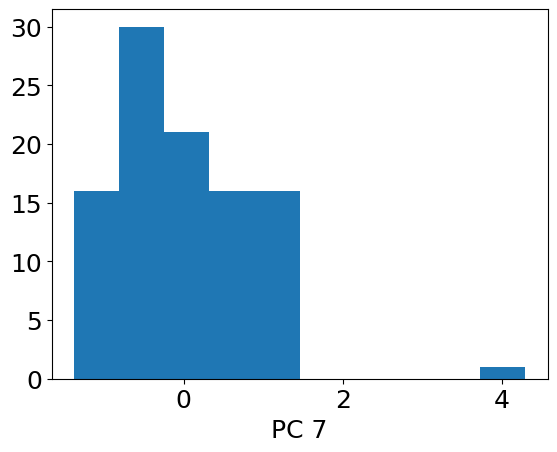

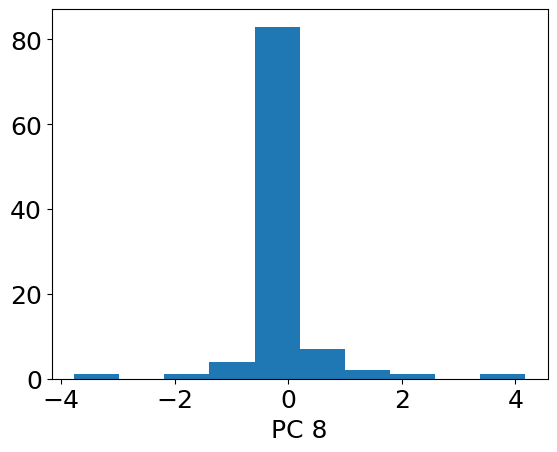

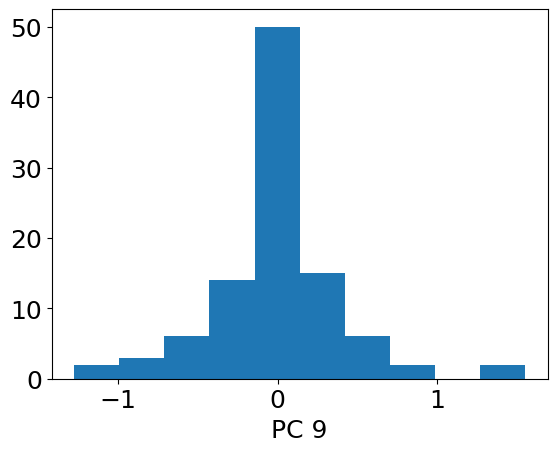

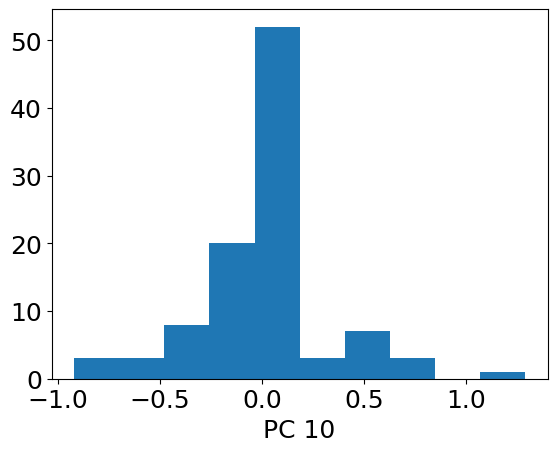

IndexError: index 10 is out of bounds for axis 1 with size 10

In [49]:
plt.hist(X_reduced[:,0])
plt.xlabel('PC 1')
plt.show()

plt.hist(X_reduced[:,1])
plt.xlabel('PC 2')
plt.show()

plt.hist(X_reduced[:,2])
plt.xlabel('PC 3')
plt.show()

plt.hist(X_reduced[:,3])
plt.xlabel('PC 4')
plt.show()

plt.hist(X_reduced[:,4])
plt.xlabel('PC 5')
plt.show()

plt.hist(X_reduced[:,5])
plt.xlabel('PC 6')
plt.show()

plt.hist(X_reduced[:,6])
plt.xlabel('PC 7')
plt.show()

plt.hist(X_reduced[:,7])
plt.xlabel('PC 8')
plt.show()

plt.hist(X_reduced[:,8])
plt.xlabel('PC 9')
plt.show()

plt.hist(X_reduced[:,9])
plt.xlabel('PC 10')
plt.show()

plt.hist(X_reduced[:,10])
plt.xlabel('PC 11')
plt.show()

In [ ]:
pickle.dump(ref_df, open("design_matrix_dim_reduc_"+str(bin_size), "wb"))

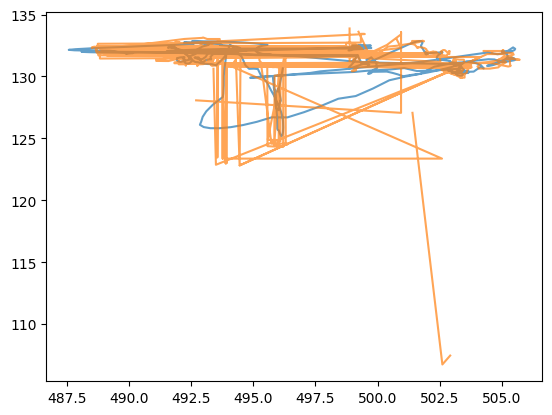

In [ ]:
plt.plot(pupil_X_smooth[0:1000], pupil_Y_smooth[0:1000], alpha=0.7)
plt.plot(pupil_X_raw[0:1000], pupil_Y_raw[0:1000], alpha=0.7)

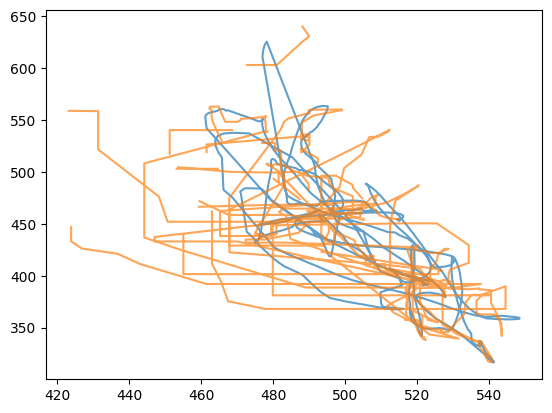

In [ ]:
plt.plot(l_paw_X_smooth[0:1000], l_paw_Y_smooth[0:1000], alpha=0.7)
plt.plot(l_paw_X_raw[0:1000], l_paw_Y_raw[0:1000], alpha=0.7)